# Lecture 18

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames=list(set(VarNames[1:]).difference(RawNames))
FeatureNames

['M_Delta_R',
 'cos_theta_r1',
 'M_TR_2',
 'MET_rel',
 'MT2',
 'S_R',
 'M_R',
 'axial_MET',
 'R',
 'dPhi_r_b']

In [3]:
!ls ../Lecture.16

Lecture.16.ipynb Lecture.16.pdf   SUSY-small.csv   SUSY.csv


In [4]:
filename="../Lecture.16/SUSY-small.csv"
df = pd.read_csv(filename, dtype='float64', names=VarNames)

In [5]:
df_sig=df[df.signal==1]
df_bkg=df[df.signal==0]

## Create Data Like Sample

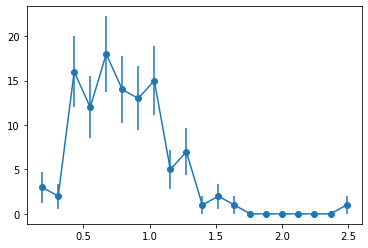

In [6]:
import math
n_bkg_expected = 100
n_sig_expected = 10

data = df_sig[:n_sig_expected]["M_TR_2"].tolist()+df_bkg[:n_bkg_expected]["M_TR_2"].tolist()

c , bin_edges= np.histogram(data,bins=20)
bin_width = bin_edges[1]-bin_edges[0]
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
error    = np.sqrt(c)

plt.errorbar(bin_centers, c, yerr=error, marker="o")
plt.show()

## Optain Probability Distributions from Simulation

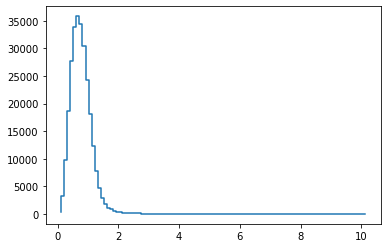

In [7]:
c_bkg_sim, sim_bin = np.histogram(df_bkg["M_TR_2"],bins=100) 
plt.step(sim_bin[1:],c_bkg_sim)

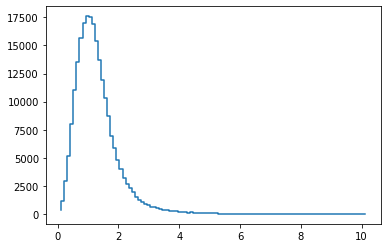

In [8]:
c_sig_sim, sim_bin = np.histogram(df_sig["M_TR_2"],bins=sim_bin)
plt.step(sim_bin[1:],c_sig_sim)

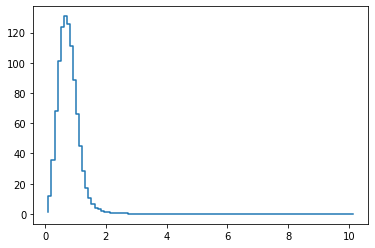

In [9]:
bin_size_sim = sim_bin[1]-sim_bin[0]
integral = sum(c_bkg_sim) * bin_size_sim
c_bkg_sim_normalized = (n_bkg_expected / integral ) * c_bkg_sim
plt.step(sim_bin[1:],c_bkg_sim_normalized)

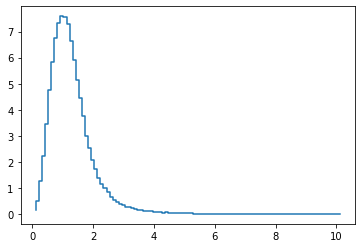

In [10]:
integral = sum(c_sig_sim) * bin_size_sim
c_sig_sim_normalized = (n_sig_expected / integral ) * c_sig_sim
plt.step(sim_bin[1:],c_sig_sim_normalized)

## Combine to Compare Data and Simulation

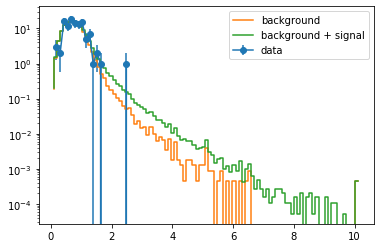

In [11]:
plt.errorbar(bin_centers, c, yerr=error, marker="o",label="data")
plt.yscale("log")
plt.step(sim_bin[1:],c_bkg_sim_normalized*bin_width,label="background")
plt.step(sim_bin[1:],(c_bkg_sim_normalized+c_sig_sim_normalized)*bin_width,label="background + signal")
plt.legend()
plt.show()

## Calculate TPR / FPR

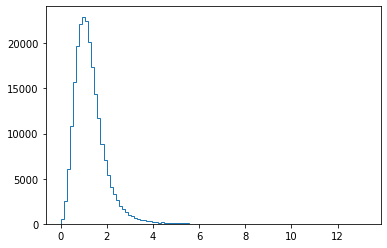

In [12]:
_=plt.hist(df_sig["M_TR_2"],bins=100,histtype="step")

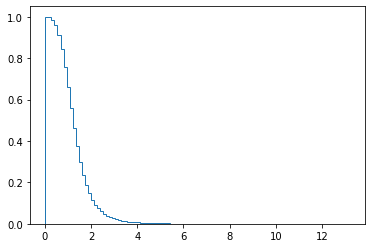

In [13]:
TPR,bins_sig,_=plt.hist(df_sig["M_TR_2"],bins=100,histtype="step",cumulative=-1,density=True)

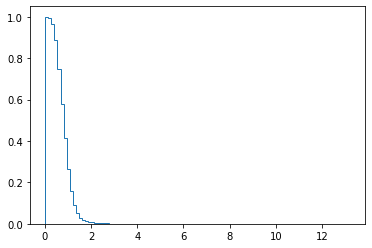

In [14]:
FPR,bins_sig,_=plt.hist(df_bkg["M_TR_2"],bins=bins_sig,histtype="step",cumulative=-1,density=True)

## Compute Significance

Assume 3 different scenarios corresponding to different numbers of signal and background events expected in data:

1. Expect $N_S=10$, $N_B=100$.
1. Expect $N_S=100$, $N_B=1000$.
1. Expect $N_S=1000$, $N_B=10000$.
1. Expect $N_S=10000$, $N_B=100000$.

Plot the significance ($\sigma_{S'}$) for each observable as function of $x_c$ for each scenario, where 

$\sigma_{S'}= \frac{N'_S}{\sqrt{N'_S+N'_B}}$

and $N'_{S,B} = \epsilon_{S,B}(x_c) * N_{S,B}$.

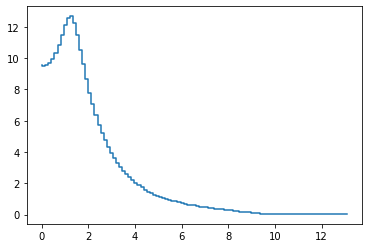

In [15]:
n_bkg_expected = 10000
n_sig_expected = 1000

n_sig_expected_prime = n_sig_expected * TPR
n_bkg_expected_prime = n_bkg_expected * FPR

sig = n_sig_expected_prime/ np.sqrt(n_sig_expected_prime + n_bkg_expected_prime )
plt.step(bins_sig[:-1],sig)

In [17]:
bins_sig[np.argmax(sig)]

1.3321864132769405

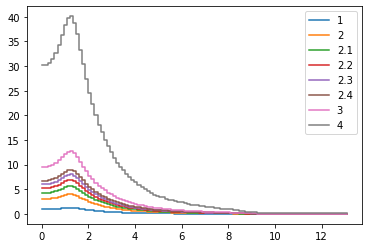

{'1': (10,
  3.7493947523392004,
  4.989067486112752,
  1.2683632796320354,
  1.3321864132769405),
 '2': (10,
  37.493947523392,
  49.89067486112753,
  4.010916864158284,
  1.3321864132769405),
 '2.1': (10,
  74.987895046784,
  99.78134972225506,
  5.672293026843611,
  1.3321864132769405),
 '2.2': (10,
  112.481842570176,
  149.67202458338258,
  6.947111793656985,
  1.3321864132769405),
 '2.3': (10,
  149.975790093568,
  199.56269944451012,
  8.021833728316569,
  1.3321864132769405),
 '2.4': (10,
  187.46973761696,
  249.45337430563762,
  8.968682760358215,
  1.3321864132769405),
 '3': (10,
  374.93947523392,
  498.90674861127525,
  12.683632796320355,
  1.3321864132769405),
 '4': (10,
  3749.3947523392003,
  4989.067486112753,
  40.10916864158285,
  1.3321864132769405)}

In [19]:
scenarios = { "1": (10,100), 
              "2": (100,1000),
              "2.1": (200,2000),
              "2.2": (300,3000),
              "2.3": (400,4000),
              "2.4": (500,5000),
              "3": (1000,10000),
              "4": (10000,100000)
            }

def compare_significance(scenarios,log=False):
    max_sigs=dict()
    for name, (n_sig_expected, n_bkg_expected) in scenarios.items():

        n_sig_expected_prime = n_sig_expected * TPR
        n_bkg_expected_prime = n_bkg_expected * FPR

        sig = n_sig_expected_prime/ np.sqrt(n_sig_expected_prime + n_bkg_expected_prime )
        plt.step(bins_sig[:-1],sig,label=name)
    
        max_i=np.argmax(sig)
        max_sigs[name]=(max_i,n_sig_expected_prime[max_i],n_bkg_expected_prime[max_i],sig[max_i],bins_sig[max_i])
        
    if log:
        plt.yscale("log")
    plt.legend()
    plt.show()
    
    return max_sigs

max_sigs = compare_significance(scenarios)
max_sigs

In [24]:
max_sigs.keys()

dict_keys(['1', '2', '2.1', '2.2', '2.3', '2.4', '3', '4'])

In [27]:
list(zip(max_sigs.keys(),*max_sigs.values()))

[('1', 10, 10, 10, 10, 10, 10, 10, 10),
 ('2',
  3.7493947523392004,
  37.493947523392,
  74.987895046784,
  112.481842570176,
  149.975790093568,
  187.46973761696,
  374.93947523392,
  3749.3947523392003),
 ('2.1',
  4.989067486112752,
  49.89067486112753,
  99.78134972225506,
  149.67202458338258,
  199.56269944451012,
  249.45337430563762,
  498.90674861127525,
  4989.067486112753),
 ('2.2',
  1.2683632796320354,
  4.010916864158284,
  5.672293026843611,
  6.947111793656985,
  8.021833728316569,
  8.968682760358215,
  12.683632796320355,
  40.10916864158285),
 ('2.3',
  1.3321864132769405,
  1.3321864132769405,
  1.3321864132769405,
  1.3321864132769405,
  1.3321864132769405,
  1.3321864132769405,
  1.3321864132769405,
  1.3321864132769405)]

In [29]:
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(max_sigs.values(), 
                               tablefmt='html',
                               headers=["bin i",'N sig','N bkg','sig','x_c'])))

bin i,N sig,N bkg,sig,x_c
10,3.74939,4.98907,1.26836,1.33219
10,37.4939,49.8907,4.01092,1.33219
10,74.9879,99.7813,5.67229,1.33219
10,112.482,149.672,6.94711,1.33219
10,149.976,199.563,8.02183,1.33219
10,187.47,249.453,8.96868,1.33219
10,374.939,498.907,12.6836,1.33219
10,3749.39,4989.07,40.1092,1.33219


In [30]:
def compare_significance(scenarios,log=False):
    max_sigs=dict()
    table=list()
    
    for name, (n_sig_expected, n_bkg_expected) in scenarios.items():

        n_sig_expected_prime = n_sig_expected * TPR
        n_bkg_expected_prime = n_bkg_expected * FPR

        sig = n_sig_expected_prime/ np.sqrt(n_sig_expected_prime + n_bkg_expected_prime )
        plt.step(bins_sig[:-1],sig,label=name+" "+str((n_sig_expected, n_bkg_expected)))
    
        max_i=np.argmax(sig)
        max_sigs[name]=(max_i,n_sig_expected_prime[max_i],n_bkg_expected_prime[max_i],sig[max_i],bins_sig[max_i])
        table.append((name,n_sig_expected, n_bkg_expected, 
                      TPR[max_i],FPR[max_i],
                      n_sig_expected_prime[max_i],n_bkg_expected_prime[max_i],sig[max_i],bins_sig[max_i],max_i)
        )
    if log:
        plt.yscale("log")
    plt.legend()
    plt.show()
    
    display(HTML(tabulate.tabulate(table, tablefmt='html',
                                   headers=["Name",'N sig','N bkg',"TPR","FPR","N sig'","N bkg'",'sig','x_c',"bin i"])))
    return max_sigs



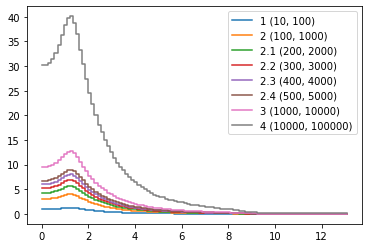

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,0.374939,0.0498907,3.74939,4.98907,1.26836,1.33219,10
2,100,1000,0.374939,0.0498907,37.4939,49.8907,4.01092,1.33219,10
2.1,200,2000,0.374939,0.0498907,74.9879,99.7813,5.67229,1.33219,10
2.2,300,3000,0.374939,0.0498907,112.482,149.672,6.94711,1.33219,10
2.3,400,4000,0.374939,0.0498907,149.976,199.563,8.02183,1.33219,10
2.4,500,5000,0.374939,0.0498907,187.47,249.453,8.96868,1.33219,10
3,1000,10000,0.374939,0.0498907,374.939,498.907,12.6836,1.33219,10
4,10000,100000,0.374939,0.0498907,3749.39,4989.07,40.1092,1.33219,10


In [32]:
scenarios = { "1": (10,100), 
              "2": (100,1000),
              "2.1": (200,2000),
              "2.2": (300,3000),
              "2.3": (400,4000),
              "2.4": (500,5000),
              "3": (1000,10000),
              "4": (10000,100000)
            }
_=compare_significance(scenarios)

## Generalize

This function above isn't general, in the sense that it relies on various objects we computed before it (namely TPR and FPR. Lets generalize to get a function that can make a similar plot for any observeable. 

One problem is that we are using `matplotlib` to compute the TPR/FPR, eventhough we never plot it. Let's instead compute it with `numpy`:


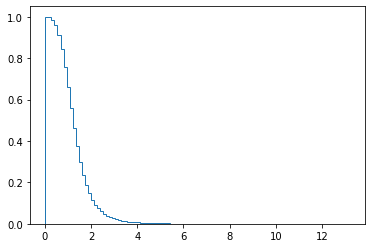

In [33]:
# Matplotlib
TPR,bins_sig,_=plt.hist(df_sig["M_TR_2"],bins=100,histtype="step",cumulative=-1,density=True)

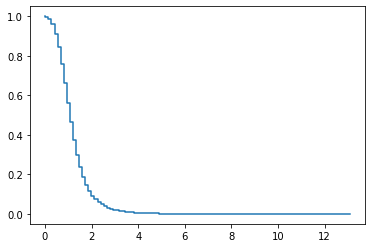

In [34]:
# compute with numpy
hist,bins_sig=np.histogram(df_sig["M_TR_2"],bins=100,density=True)
TPR = np.cumsum(hist[::-1])[::-1] * (bins_sig[1]-bins_sig[0])

# plot with matplotlib
plt.step(bins_sig[:-1],TPR)
plt.show()

Lets write this into a function:

In [35]:
def compute_rate(d,bins=100):
    hist,bins_=np.histogram(d,bins=bins,density=True)
    R = np.cumsum(hist[::-1])[::-1] * (bins_[1]-bins_[0])
    return R,bins_


Note that this function onlhy works for the first possible selection criteria (from your lab):

1. $x > x_c$
2. $x < x_c$
3. $|x - x_0| > x_c$
4. $|x - x_0| < x_c$

And actually, scenarios 3 and 4 are more challenging to implement.

Now put it all together:

In [36]:
def compare_significance(df_sig, df_bkg,
                         obs_name,
                         scenarios,bins=100,log=False):
        
    TPR,bins_sig = compute_rate(df_sig[obs_name],bins=bins)
    FPR,bins_sig = compute_rate(df_bkg[obs_name],bins=bins_sig)
    
    max_sigs=dict()
    table=list()
    
    for name, (n_sig_expected, n_bkg_expected) in scenarios.items():

        n_sig_expected_prime = n_sig_expected * TPR
        n_bkg_expected_prime = n_bkg_expected * FPR

        sig = n_sig_expected_prime/ np.sqrt(n_sig_expected_prime + n_bkg_expected_prime )
        plt.step(bins_sig[:-1],sig,label=name+" "+str((n_sig_expected, n_bkg_expected)))
    
        max_i=np.argmax(sig)
        max_sigs[name]=(max_i,n_sig_expected_prime[max_i],n_bkg_expected_prime[max_i],sig[max_i],bins_sig[max_i])
        table.append((name,n_sig_expected, n_bkg_expected, 
                      TPR[max_i],FPR[max_i],
                      n_sig_expected_prime[max_i],n_bkg_expected_prime[max_i],sig[max_i],bins_sig[max_i],max_i)
        )
    if log:
        plt.yscale("log")
    plt.legend()
    plt.show()
    
    display(HTML(tabulate.tabulate(table, tablefmt='html',
                                   headers=["Name",'N sig','N bkg',"TPR","FPR","N sig'","N bkg'",'sig','x_c',"bin i"])))
    return max_sigs


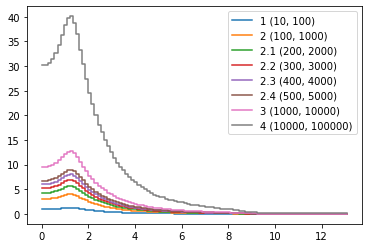

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,0.374939,0.0498907,3.74939,4.98907,1.26836,1.33219,10
2,100,1000,0.374939,0.0498907,37.4939,49.8907,4.01092,1.33219,10
2.1,200,2000,0.374939,0.0498907,74.9879,99.7813,5.67229,1.33219,10
2.2,300,3000,0.374939,0.0498907,112.482,149.672,6.94711,1.33219,10
2.3,400,4000,0.374939,0.0498907,149.976,199.563,8.02183,1.33219,10
2.4,500,5000,0.374939,0.0498907,187.47,249.453,8.96868,1.33219,10
3,1000,10000,0.374939,0.0498907,374.939,498.907,12.6836,1.33219,10
4,10000,100000,0.374939,0.0498907,3749.39,4989.07,40.1092,1.33219,10


In [48]:
scenarios = { "1": (10,100), 
              "2": (100,1000),
              "2.1": (200,2000),
              "2.2": (300,3000),
              "2.3": (400,4000),
              "2.4": (500,5000),
              "3": (1000,10000),
              "4": (10000,100000)
            }
_=compare_significance(df_sig,df_bkg,"M_TR_2",scenarios)

In [39]:
my_obs= ['MET',
 'MET_phi',
 'MET_rel',
 'axial_MET',
 'M_R',
 'M_TR_2',
 'R',
 'MT2',
 'S_R',
 'M_Delta_R',
 'dPhi_r_b',
 'cos_theta_r1']

MET


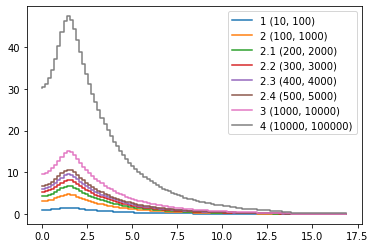

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,0.32676,0.0148142,3.2676,1.48142,1.49943,1.53595,9
2,100,1000,0.32676,0.0148142,32.676,14.8142,4.74162,1.53595,9
2.1,200,2000,0.32676,0.0148142,65.3519,29.6284,6.70566,1.53595,9
2.2,300,3000,0.32676,0.0148142,98.0279,44.4426,8.21272,1.53595,9
2.3,400,4000,0.32676,0.0148142,130.704,59.2567,9.48324,1.53595,9
2.4,500,5000,0.32676,0.0148142,163.38,74.0709,10.6026,1.53595,9
3,1000,10000,0.32676,0.0148142,326.76,148.142,14.9943,1.53595,9
4,10000,100000,0.32676,0.0148142,3267.6,1481.42,47.4162,1.53595,9


MET_phi


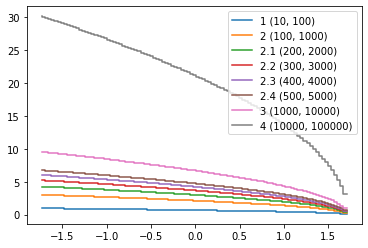

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,1,1,10,100,0.953463,-1.72711,0
2,100,1000,1,1,100,1000,3.01511,-1.72711,0
2.1,200,2000,1,1,200,2000,4.26401,-1.72711,0
2.2,300,3000,1,1,300,3000,5.22233,-1.72711,0
2.3,400,4000,1,1,400,4000,6.03023,-1.72711,0
2.4,500,5000,1,1,500,5000,6.742,-1.72711,0
3,1000,10000,1,1,1000,10000,9.53463,-1.72711,0
4,10000,100000,1,1,10000,100000,30.1511,-1.72711,0


MET_rel


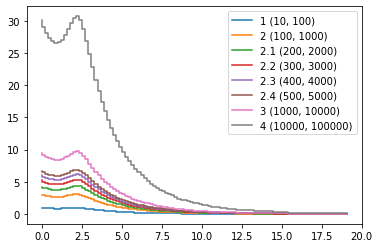

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,0.146559,0.00809957,1.46559,0.809957,0.971561,2.30909,12
2,100,1000,0.146559,0.00809957,14.6559,8.09957,3.07235,2.30909,12
2.1,200,2000,0.146559,0.00809957,29.3119,16.1991,4.34495,2.30909,12
2.2,300,3000,0.146559,0.00809957,43.9678,24.2987,5.32146,2.30909,12
2.3,400,4000,0.146559,0.00809957,58.6237,32.3983,6.14469,2.30909,12
2.4,500,5000,0.146559,0.00809957,73.2797,40.4979,6.86998,2.30909,12
3,1000,10000,0.146559,0.00809957,146.559,80.9957,9.71561,2.30909,12
4,10000,100000,0.146559,0.00809957,1465.59,809.957,30.7235,2.30909,12


axial_MET


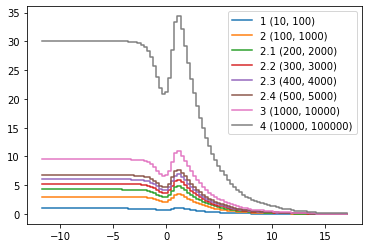

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,0.13647,0.00211261,1.3647,0.211261,1.08709,1.34388,45
2,100,1000,0.13647,0.00211261,13.647,2.11261,3.43767,1.34388,45
2.1,200,2000,0.13647,0.00211261,27.2939,4.22522,4.8616,1.34388,45
2.2,300,3000,0.13647,0.00211261,40.9409,6.33783,5.95422,1.34388,45
2.3,400,4000,0.13647,0.00211261,54.5879,8.45044,6.87534,1.34388,45
2.4,500,5000,0.13647,0.00211261,68.2349,10.5631,7.68686,1.34388,45
3,1000,10000,0.13647,0.00211261,136.47,21.1261,10.8709,1.34388,45
4,10000,100000,0.13647,0.00211261,1364.7,211.261,34.3767,1.34388,45


M_R


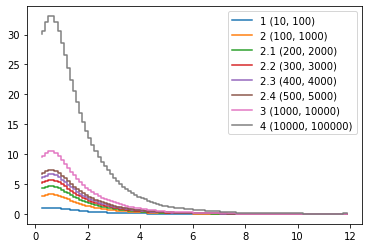

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,0.749936,0.439256,7.49936,43.9256,1.04577,0.741439,4
2,100,1000,0.749936,0.439256,74.9936,439.256,3.30702,0.741439,4
2.1,200,2000,0.749936,0.439256,149.987,878.512,4.67683,0.741439,4
2.2,300,3000,0.749936,0.439256,224.981,1317.77,5.72793,0.741439,4
2.3,400,4000,0.749936,0.439256,299.974,1757.02,6.61404,0.741439,4
2.4,500,5000,0.749936,0.439256,374.968,2196.28,7.39472,0.741439,4
3,1000,10000,0.749936,0.439256,749.936,4392.56,10.4577,0.741439,4
4,10000,100000,0.749936,0.439256,7499.36,43925.6,33.0702,0.741439,4


M_TR_2


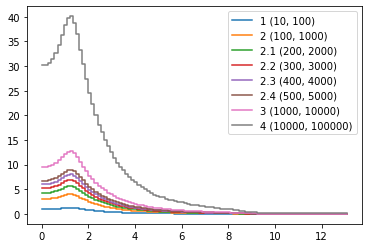

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,0.374939,0.0498907,3.74939,4.98907,1.26836,1.33219,10
2,100,1000,0.374939,0.0498907,37.4939,49.8907,4.01092,1.33219,10
2.1,200,2000,0.374939,0.0498907,74.9879,99.7813,5.67229,1.33219,10
2.2,300,3000,0.374939,0.0498907,112.482,149.672,6.94711,1.33219,10
2.3,400,4000,0.374939,0.0498907,149.976,199.563,8.02183,1.33219,10
2.4,500,5000,0.374939,0.0498907,187.47,249.453,8.96868,1.33219,10
3,1000,10000,0.374939,0.0498907,374.939,498.907,12.6836,1.33219,10
4,10000,100000,0.374939,0.0498907,3749.39,4989.07,40.1092,1.33219,10


R


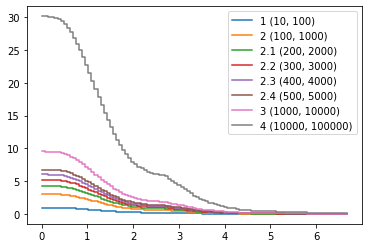

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,1,1,10,100,0.953463,0.0110889,0
2,100,1000,1,1,100,1000,3.01511,0.0110889,0
2.1,200,2000,1,1,200,2000,4.26401,0.0110889,0
2.2,300,3000,1,1,300,3000,5.22233,0.0110889,0
2.3,400,4000,1,1,400,4000,6.03023,0.0110889,0
2.4,500,5000,1,1,500,5000,6.742,0.0110889,0
3,1000,10000,1,1,1000,10000,9.53463,0.0110889,0
4,10000,100000,1,1,10000,100000,30.1511,0.0110889,0


MT2


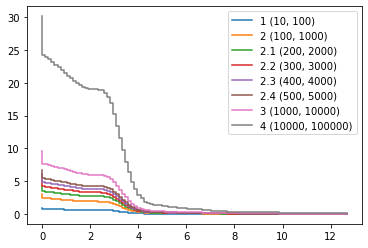

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,1,1,10,100,0.953463,0,0
2,100,1000,1,1,100,1000,3.01511,0,0
2.1,200,2000,1,1,200,2000,4.26401,0,0
2.2,300,3000,1,1,300,3000,5.22233,0,0
2.3,400,4000,1,1,400,4000,6.03023,0,0
2.4,500,5000,1,1,500,5000,6.742,0,0
3,1000,10000,1,1,1000,10000,9.53463,0,0
4,10000,100000,1,1,10000,100000,30.1511,0,0


S_R


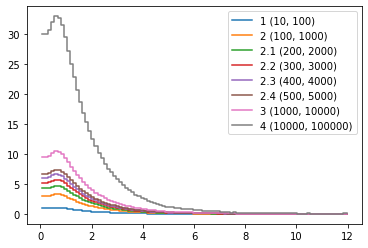

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,0.82438,0.54024,8.2438,54.024,1.04471,0.667132,5
2,100,1000,0.82438,0.54024,82.438,540.24,3.30366,0.667132,5
2.1,200,2000,0.82438,0.54024,164.876,1080.48,4.67208,0.667132,5
2.2,300,3000,0.82438,0.54024,247.314,1620.72,5.72211,0.667132,5
2.3,400,4000,0.82438,0.54024,329.752,2160.96,6.60732,0.667132,5
2.4,500,5000,0.82438,0.54024,412.19,2701.2,7.38721,0.667132,5
3,1000,10000,0.82438,0.54024,824.38,5402.4,10.4471,0.667132,5
4,10000,100000,0.82438,0.54024,8243.8,54024,33.0366,0.667132,5


M_Delta_R


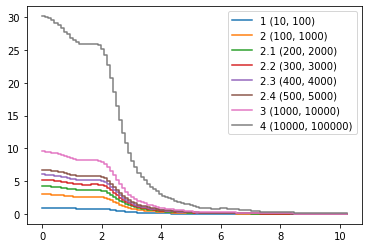

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,1,1,10,100,0.953463,0.00445562,0
2,100,1000,1,1,100,1000,3.01511,0.00445562,0
2.1,200,2000,1,1,200,2000,4.26401,0.00445562,0
2.2,300,3000,1,1,300,3000,5.22233,0.00445562,0
2.3,400,4000,1,1,400,4000,6.03023,0.00445562,0
2.4,500,5000,1,1,500,5000,6.742,0.00445562,0
3,1000,10000,1,1,1000,10000,9.53463,0.00445562,0
4,10000,100000,1,1,10000,100000,30.1511,0.00445562,0


dPhi_r_b


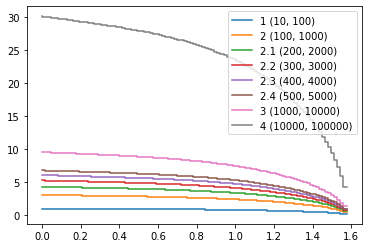

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,1,1,10,100,0.953463,8.22401e-06,0
2,100,1000,1,1,100,1000,3.01511,8.22401e-06,0
2.1,200,2000,1,1,200,2000,4.26401,8.22401e-06,0
2.2,300,3000,1,1,300,3000,5.22233,8.22401e-06,0
2.3,400,4000,1,1,400,4000,6.03023,8.22401e-06,0
2.4,500,5000,1,1,500,5000,6.742,8.22401e-06,0
3,1000,10000,1,1,1000,10000,9.53463,8.22401e-06,0
4,10000,100000,1,1,10000,100000,30.1511,8.22401e-06,0


cos_theta_r1


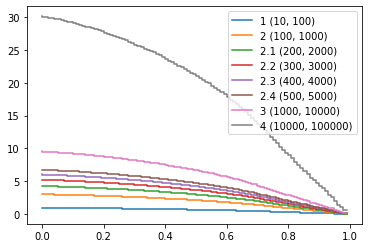

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,1,1,10,100,0.953463,3.52031e-07,0
2,100,1000,1,1,100,1000,3.01511,3.52031e-07,0
2.1,200,2000,1,1,200,2000,4.26401,3.52031e-07,0
2.2,300,3000,1,1,300,3000,5.22233,3.52031e-07,0
2.3,400,4000,1,1,400,4000,6.03023,3.52031e-07,0
2.4,500,5000,1,1,500,5000,6.742,3.52031e-07,0
3,1000,10000,1,1,1000,10000,9.53463,3.52031e-07,0
4,10000,100000,1,1,10000,100000,30.1511,3.52031e-07,0


In [40]:
for obs in my_obs:
    print(obs)
    _=compare_significance(df_sig,df_bkg,obs,scenarios)
    

## Making Selections

Recall that with Pandas, you can select a subset of your data:

In [41]:
df_sig["M_TR_2"]>1.35029

1         False
2         False
3         False
4         False
8          True
          ...  
499988    False
499991    False
499994    False
499996     True
499997    False
Name: M_TR_2, Length: 229245, dtype: bool

Some basic checks:

In [42]:
sum(df_sig["M_TR_2"]>1.35029)

83371

In [43]:
df_sig.shape

(229245, 19)

In [44]:
sum(df_sig["M_TR_2"]>1.35029)/df_sig.shape[0]

0.363676416061419

Now lets select on one variable and look how the significance changes:

In [45]:
df_sig_1 = df_sig[df_sig["M_TR_2"]>1.35029]
df_bkg_1 = df_bkg[df_bkg["M_TR_2"]>1.35029]

In [46]:
print(df_sig_1.shape)
print(df_bkg_1.shape)

(83371, 19)
(12495, 19)


In [53]:
scenarios

{'1': (10, 100),
 '2': (100, 1000),
 '2.1': (200, 2000),
 '2.2': (300, 3000),
 '2.3': (400, 4000),
 '2.4': (500, 5000),
 '3': (1000, 10000),
 '4': (10000, 100000)}

In [58]:
eff_s = df_sig_1.shape[0]/df_sig.shape[0]
eff_b = df_bkg_1.shape[0]/df_bkg.shape[0]

print(eff_s,eff_b)

0.363676416061419 0.04614873224871194


In [64]:
scenarios_1 =dict(zip(scenarios.keys(),map(lambda x: (eff_s*x[0],eff_b*x[1]),scenarios.values())))
scenarios_1

{'1': (3.63676416061419, 4.614873224871194),
 '2': (36.3676416061419, 46.14873224871194),
 '2.1': (72.7352832122838, 92.29746449742387),
 '2.2': (109.10292481842569, 138.44619674613583),
 '2.3': (145.4705664245676, 184.59492899484775),
 '2.4': (181.8382080307095, 230.7436612435597),
 '3': (363.676416061419, 461.4873224871194),
 '4': (3636.7641606141897, 4614.873224871194)}

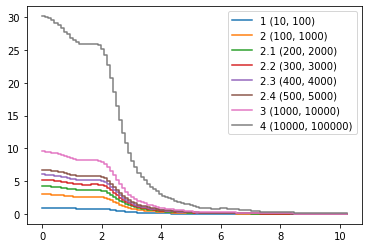

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,10,100,1,1,10,100,0.953463,0.00445562,0
2,100,1000,1,1,100,1000,3.01511,0.00445562,0
2.1,200,2000,1,1,200,2000,4.26401,0.00445562,0
2.2,300,3000,1,1,300,3000,5.22233,0.00445562,0
2.3,400,4000,1,1,400,4000,6.03023,0.00445562,0
2.4,500,5000,1,1,500,5000,6.742,0.00445562,0
3,1000,10000,1,1,1000,10000,9.53463,0.00445562,0
4,10000,100000,1,1,10000,100000,30.1511,0.00445562,0


In [67]:
_=compare_significance(df_sig,df_bkg,"M_Delta_R",scenarios)

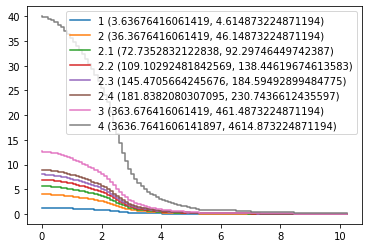

Name,N sig,N bkg,TPR,FPR,N sig',N bkg',sig,x_c,bin i
1,3.63676,4.61487,1,1,3.63676,4.61487,1.26603,0.00687303,0
2,36.3676,46.1487,1,1,36.3676,46.1487,4.00355,0.00687303,0
2.1,72.7353,92.2975,1,1,72.7353,92.2975,5.66187,0.00687303,0
2.2,109.103,138.446,1,1,109.103,138.446,6.93435,0.00687303,0
2.3,145.471,184.595,1,1,145.471,184.595,8.0071,0.00687303,0
2.4,181.838,230.744,1,1,181.838,230.744,8.95221,0.00687303,0
3,363.676,461.487,1,1,363.676,461.487,12.6603,0.00687303,0
4,3636.76,4614.87,1,1,3636.76,4614.87,40.0355,0.00687303,0


In [68]:
_=compare_significance(df_sig_1,df_bkg_1,"M_Delta_R",scenarios_1)